# Image cropping for image with two eyes

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [73]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

In [74]:
def crop_photo_with_two_eyes(image_path):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    face = face_cascade.detectMultiScale(gray_image,1.3,5)
    
    if len(face)==1:
        x,y,w,h = face[0]
        image = image[y:y+h,x:x+w]
        #gray_image = gray_image[y:y+h,x:x+w]
        eyes = eye_cascade.detectMultiScale(image)
        if len(eyes)>=2:
            return image
    else:
        return None

# Cropped image wavelet transformation

In [75]:
import numpy as np
import pywt
import cv2

In [76]:
def wavelet_transformation(image,mode="db1",level=5):
    image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    image = np.float32(image)
    image = image/255
    coeffs = pywt.wavedec2(image,mode,level=level)
    coeffs_H = list(coeffs)
    coeffs_H[0] *=0
    image_H = pywt.waverec2(coeffs_H,mode)
    image_H *= 255
    image_H = np.uint8(image_H)
    return image_H

# To get list of folders

In [77]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [78]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [79]:
img_dirs

['./dataset/cropped',
 './dataset/lionel_messi',
 './dataset/maria_sharapova',
 './dataset/roger_federer',
 './dataset/serena_williams',
 './dataset/virat_kohli']

# To create new folder

In [80]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [81]:
cropped_image_dirs = []
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1] 
    for entry in os.scandir(img_dir):
        roi_color = crop_photo_with_two_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path,roi_color)
            count +=1

Generating cropped images in folder:  ./dataset/cropped/lionel_messi
Generating cropped images in folder:  ./dataset/cropped/maria_sharapova
Generating cropped images in folder:  ./dataset/cropped/roger_federer
Generating cropped images in folder:  ./dataset/cropped/serena_williams
Generating cropped images in folder:  ./dataset/cropped/virat_kohli


In [82]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'lionel_messi': ['./dataset/cropped/lionel_messi\\lionel_messi1.png',
  './dataset/cropped/lionel_messi\\lionel_messi10.png',
  './dataset/cropped/lionel_messi\\lionel_messi11.png',
  './dataset/cropped/lionel_messi\\lionel_messi12.png',
  './dataset/cropped/lionel_messi\\lionel_messi13.png',
  './dataset/cropped/lionel_messi\\lionel_messi14.png',
  './dataset/cropped/lionel_messi\\lionel_messi15.png',
  './dataset/cropped/lionel_messi\\lionel_messi16.png',
  './dataset/cropped/lionel_messi\\lionel_messi17.png',
  './dataset/cropped/lionel_messi\\lionel_messi18.png',
  './dataset/cropped/lionel_messi\\lionel_messi19.png',
  './dataset/cropped/lionel_messi\\lionel_messi2.png',
  './dataset/cropped/lionel_messi\\lionel_messi20.png',
  './dataset/cropped/lionel_messi\\lionel_messi21.png',
  './dataset/cropped/lionel_messi\\lionel_messi22.png',
  './dataset/cropped/lionel_messi\\lionel_messi23.png',
  './dataset/cropped/lionel_messi\\lionel_messi24.png',
  './dataset/cropped/lionel_messi\

In [83]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

In [84]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = wavelet_transformation(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

In [85]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(135, 4096)

# Model Trailing

In [86]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8235294117647058

In [88]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.73      0.89      0.80         9
           2       1.00      0.50      0.67         4
           3       0.83      0.71      0.77         7
           4       0.75      1.00      0.86         6

    accuracy                           0.82        34
   macro avg       0.86      0.80      0.81        34
weighted avg       0.85      0.82      0.82        34



# With grid search

In [89]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [90]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [91]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.761905,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.621905,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.751905,{'logisticregression__C': 1}


In [92]:
#best_estimators

In [93]:
best_estimators['svm'].score(X_test,y_test)

0.8235294117647058

In [94]:
best_estimators['random_forest'].score(X_test,y_test)

0.7352941176470589

In [95]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8235294117647058

In [96]:
best_clf = best_estimators['logistic_regression']

In [97]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[8, 0, 0, 0, 0],
       [0, 8, 0, 1, 0],
       [0, 0, 4, 0, 0],
       [0, 2, 1, 4, 0],
       [0, 0, 1, 1, 4]], dtype=int64)

Text(69.0, 0.5, 'Truth')

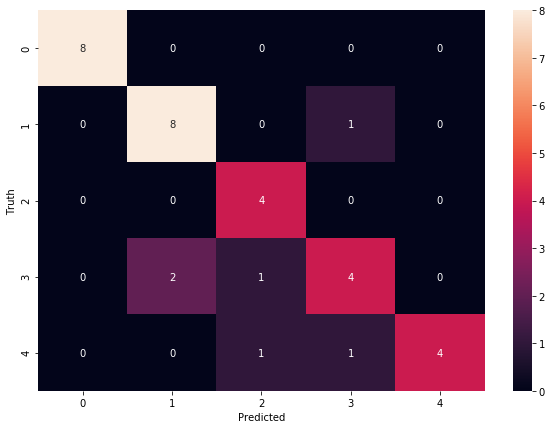

In [98]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')